In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import pylab
import matplotlib as mpl

font = {'size'   : 12}

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
}
pylab.rcParams.update(params)
plt.rc('font', **font)

In this project we will be investigating adaptive mesh generation for boundary value problems in one dimension. 

The idea is quite simple, we must select a mesh or number of points where we discretize the domain $[a,b]$ to solve a BVP numerically.  The most straight forward way to proceed is to define a uniform mesh by dividing the domain into subdomains of equal size, that is we use a mesh given by $\{x_{i}\}= a +ih$ where $h=\frac{(b-a)}{N}$, $N$ is a positive integer and $i$ goes from 0 to N inclusive. The problem with that approach is that it only works well for solutions that more or less behave the same way across all of the domain. Most real world functions do not meet this criteria. If the function is constant in one location on the domain but exhibits rapid change in another location then a uniform mesh forces us to either waste computional resources by choosing a mesh size that is appropriately small for the areas of rapid change but wasteful for areas of no to small change or we are forced to incur large errors in the locations of high change by selecting a mesh size that is appropraitely large for the locations of low change.

To illustrate the differences in function behaviour I have plotted a couple functions.

In [ ]:
#@title Plotting routine.
def derivplot(f,ex):
  plt.figure(figsize=(11,8))
  eval=f(ex)
  f=eval
  plt.plot(ex,f,'*-')
  plt.xlabel("x")
  plt.ylabel('$f(x)$')
  
  plt.show()



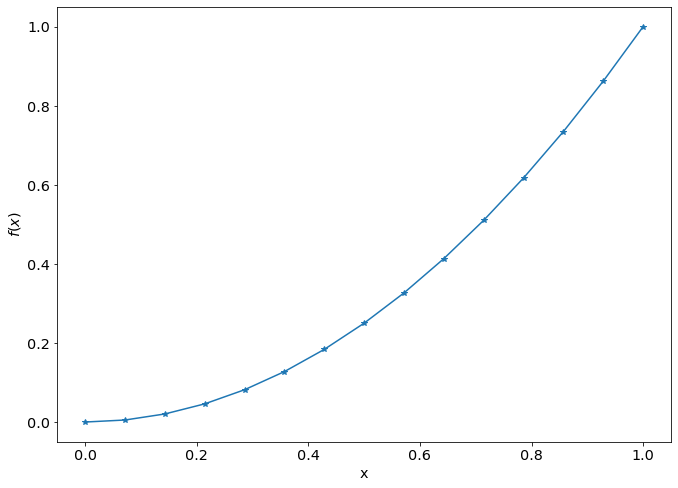

In [ ]:
#@title $f(x)=x^{2}.$
x=np.linspace(0,1,15,endpoint=True)

def f(x):
  return x**2

derivplot(f,x)

As you can see for this function ,$f(x)=x^{2}$, it makes perfect sense to use a uniform mesh as the rate of change of the function is constant over the domain. But what about this function

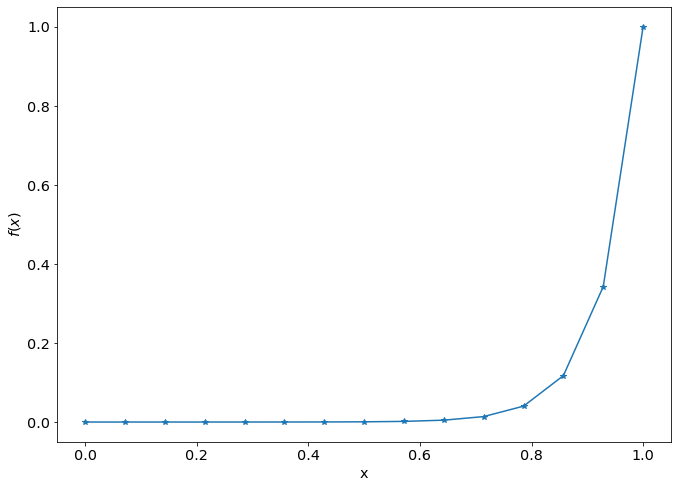

In [ ]:
#@title $f(x) = \frac{e^{λx}-1}{e^{λ}-1}$ on uniform mesh.
def f(x):
  λ=15
  return (np.exp(λ*x)-1)/(np.exp(λ)-1)

derivplot(f,x)

It doesn't really make much sense to use a uniform grid here anymore. To sum up, we want to take long strides in areas where little to no change occurs and to tip-toe in areas of rapid change. Something like this would be a more sensible mesh for this fucntion.

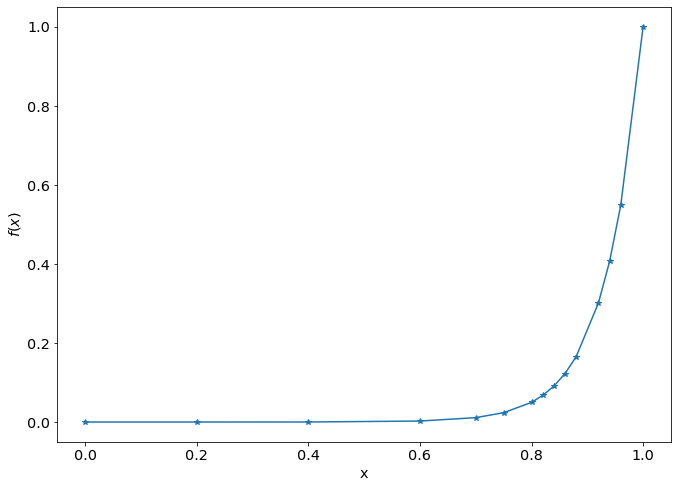

In [ ]:
#@title $f(x) = \frac{e^{λx}-1}{e^{λ}-1}$ on non-uniform mesh.
ex=np.array([0.        , 0.2, 0.4, 0.6, 0.7,
       0.75, 0.8, 0.82, 0.84, 0.86,
       0.88, 0.92, 0.94, 0.96, 1.        ])


derivplot(f,ex)

This seems like it would be a more reasonable mesh given the boundary layer. The question is now, how do we mathematically determine the ideal mesh for a given boundary layer? The equidistribution principle will be used to this end. The equidistribution principle  involves finding a mesh $\{x_{i}\}$ which evenly distributes a function $M(x,u(x))$ among the subintervals of the domain. In other words:


\begin{equation}
 \int_{x_{1}}^{x_{2}} M(x,u(x))\,dx = ... = \int_{x_{N-1}}^{x_{N}} M(x,u(x))\,dx .  \:\: \:\:\:\:\:\:\:(1)
\end{equation}

The function $M(x,u(x))$ is a given as a measure of error in the solution, meaning $M$ is large where the solution is in a region of rapid change and vice versa. This means that when equation $(1)$ is satisfied, the error is distributed evenly among all of the subintervals of the domain. The specifics for implementing this are outlined below.

##Detailed Algorithm for finding equidistributing mesh for BVP:


1.   Replace the physical co-ordinate $x$ with the computational co-ordinate $ξ$ where $ξ_{i} = \frac{i}{N}$ and $x_{i}= x(ξ_{i})$. We are attempting the find the mapping from $ξ$ to $x$ that satisfies the equidistribution problem.
2.   From equation $(1)$ and using that $x_{i}= x(ξ_{i})$ we obtain:

\begin{equation}
 \int_{x_{i-1}}^{x_{i}} M(x,u(x))\,dx = \frac{1}{N}\int_{0}^{1} M(x,u(x))\,dx .  \:\: \:\:\:\:\:\:\:(2)
\end{equation}
 Equation $(2)$ is equivilant to the second order nonlinear (due to $u$'s dependance on $x$) differential equation:
\begin{equation}
\frac{d}{dξ} (M(x,u(x)\frac{dx}{dξ}) = 0 , \:\: \:\:\:\:\:\:\:(3)
\end{equation}
subject to the boundary conditions $x(0)=0$ and $x(1)=1$.

3. Discertize equation (3) and obtain the following system of coupled equations for $i=1,....N-1$:

\begin{equation}
\frac{1}{2Δξ^{2}}[(M(x_{i+1}))+M(x_{i})(x_{i+1}-x_i) - (M(x_{i})+M(x_{i-1}))(x_{i}-x_{i-1})] =0 \:\: \:\:\:(4)
\end{equation} 

subject to $x_{0}=0$ and $x_{1}= 1$, we denote this system of equations as $\textbf{G} =0$.

4. Solve this system for the unkown values of $x$ by using the multidemnsional version of Newton's method,
\begin{equation}
 \textbf{x}^{k+1} =\textbf{x}^{k}+\textbf{δ}^{k} \:\:\:\:(5)
 \end{equation}
  where $\textbf{δ}^{k} $ is the solution for 
  \begin{equation}
  \textbf{J}(\textbf{x}^k)\textbf{δ}^k= -\textbf{G}(\textbf{x}^k) \:\:\:\:(6)
  \end{equation}
  and $\textbf{J}(\textbf{x}^k)$ is the Jacobian Matrix(entries given later) $\frac{δ}{δx}(\textbf{G}(\textbf{x}^k))$.

5. Equation $(6)$ is solved, using a standard linear solver, for $\textbf{δ}^k$ which is then inserted back into equation $(5)$ so that  $\textbf{x}^{k+1}$ can be obtained, the next iteration involves taking $\textbf{x}^{k+1}$ as $\textbf{x}^{k}$ by plugging it into $\textbf{J}$ and $\textbf{G}$ and repeating the previous steps. This is done until the norm of $\textbf{δ}^k$ is smaller than some preset tolerance. The final $\textbf{x}^{k+1}$ is the mesh that satisfies the equidistribution principle.

### Some practical considerations

1. The initial $x$ is chosen to be a uniform mesh on the domain.

2. The Jacobian entries are given by:
$$
\frac{\partial G_{i}}{\partial x_{i}} =  -2M(x_{i})-M(x_{i-1})- M(x_{i+1}) +\frac{\partial M(x_{i})}{\partial x_{i}}(x_{i+1}-2x_{i}+x_{i-1})
$$

$$
\frac{\partial G_{i}}{\partial x_{i+1}} =  M(x_{i+1})+ M(x_{i}) +\frac{\partial M(x_{i+1})}{\partial x_{i+1}}(x_{i+1}-x_{i})
$$


$$
\frac{\partial G_{i}}{\partial x_{i-1}} =  M(x_{i})+ M(x_{i-1}) +\frac{\partial M(x_{i-1})}{\partial x_{i-1}}(x_{i-1}-x_{i})
$$

3. We must select an $M(x,u(x))$!


#Part 1
 Our first couice of M will be the function $M(x) = 1+Cx^{2}$ where $C$ is a paremter that determines how sharp the boundary layer is.

In [ ]:
N=15
ex=np.linspace(0,1,N,endpoint=True)

In [ ]:
#@title Functions for constructing $M$, $\frac{dM}{dx}$ and $\textbf{G}$. 
def M(C,x):
  return 1+C*x**2

def dM(C,x):
  return 2*C*x

def makeG(x,M,C):
  N= len(x)
  exi=x
  dexi=exi[1]-exi[0]
  G=np.zeros(N-2)
  #1/(2*dexi**2)*
  for i in range(1,N-1):
    G[i-1]= (  (M(C,x[i+1]) +  M(C,x[i]))   * (x[i+1] - x[i])- \
                          (   M(C,x[i])   +  M(C,x[i-1])) * (x[i]   - x[i-1])  \
                          )
  return G

In [ ]:
#@title Functions for constructing $J$
def mydiag(C,M,dM,x,xPlus1,xMinus1):
  gixi= -2*M(C,x) -M(C,xMinus1)-M(C,xPlus1)+ dM(C,x)*(xPlus1-2*x+xMinus1)
  return gixi

def subDiag(C,M,dM,x,xMinus1):
  return M(C,x)+M(C,xMinus1) +dM(C,xMinus1)*(xMinus1-x)

def supDiag(C,M,dM,x,xPlus1):
  return M(C,xPlus1) +M(C,x) +dM(C,xPlus1)*(xPlus1-x)

def makeJ(x,M,dM,C):
  dim=len(x)-2
  exi=x
  dexi=exi[1]-exi[0]
  J= np.zeros(dim*dim).reshape((dim,dim))
  #print(mydiag(C,M,dM,x[1],x[2],x[0]))
  #first row
  J[0][0]=mydiag(C,M,dM,x[1],x[2],x[0])
  J[0][1]= supDiag(C,M,dM,x[1],x[2])
  #last row
  J[-1][-1]=mydiag(C,M,dM,x[-2],x[-1],x[-3])
  J[-1][-2] = subDiag(C,M,dM,x[-2],x[-3])

  for i in range(1,len(J)-1):

    J[i][i]   = mydiag(C,M,dM, x[i+1],x[i+2],x[i])
    J[i][i-1] = subDiag(C,M,dM,x[i+1],       x[i])
    J[i][i+1] = supDiag(C,M,dM,x[i+1],x[i+2]     )
  return J

In [ ]:
#@title Newton Solver
def Newton(ex,C,M,dM):
    G=makeG(ex,M,C)
    J=makeJ(ex,M,dM,C)
    delta=linalg.solve(J,G)
    norm = np.abs(np.amax(delta))
    xnew=np.zeros(len(ex))
    xnew[-1]=1
    xnew[1:-1]= ex[1:-1]-delta
    i=1
    while (norm>10**-6):
        G=makeG(xnew,M,C)
        J=makeJ(xnew,M,dM,C)
        delta=linalg.solve(J,G)
        xnew[1:-1]= xnew[1:-1]-delta
        norm = np.abs(np.amax(delta))
        i=i+1
    return i,xnew

In [ ]:
#@title Main function runs all routine and produces plots.
def getDeltas(x):
  deltas= np.zeros(len(x)-1)
  for i in range(len(deltas)):
    deltas[i]= x[i+1]-x[i]
  return deltas

def main(ex,C,M,dM):

  fig, (ax1,ax2) = plt.subplots(2,figsize=(12,10))
  for i in range(len(C)):
    xnew= Newton(ex,C[i],M,dM)[1]
    dex= getDeltas(xnew)
    ax1.plot(ex,xnew,label='C='+str(C[i]))
    ax2.plot(ex[1:],dex,label='C='+str(C[i]))
  ax1.set(xlabel='ξ',ylabel='x')
  ax2.set(xlabel='ξ',ylabel='Δx')
  ax1.legend()
  ax2.legend()
  plt.show()

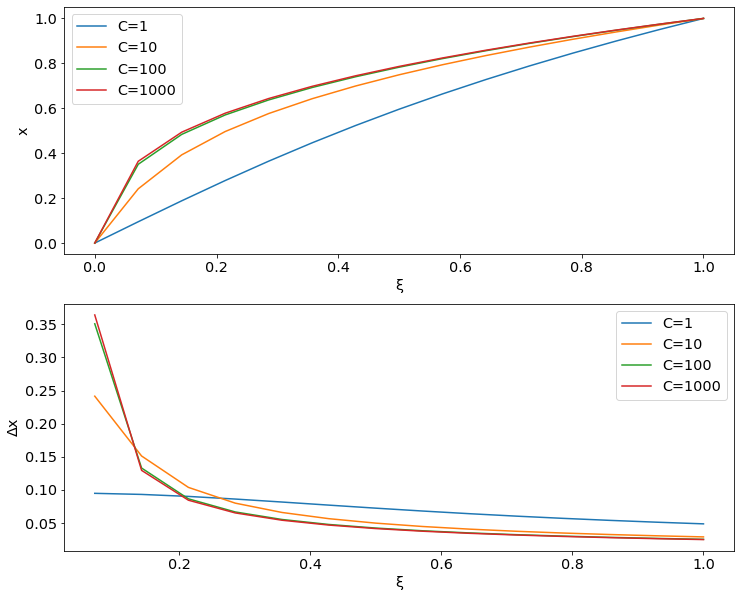

In [ ]:
C=[1,10,100,1000]
main(ex,C,M,dM)

As can be seen in the above plots, the mesh size is mostly uniform for on ξ for $C=1$, as $C$ is increased the boundary layer becomes sharper near $x=1$ and an increasingly skewed, in the sense that more points are needed at the tail of the domain, mesh is needed to equidistribute the error. This can be seen by $Δx$ getting larger as $C$ increases for the first few mesh points which is done to 'make way' for the increase in mesh points near $x=1$  

In [ ]:
out=Newton(ex,1000,M,dM)
d=getDeltas(out[1])
print(out[0],np.amin(d),np.amax(d))

10 0.02509522954746879 0.36410102319179144


$$
\begin{aligned}
& \text {Table 1.1. A Jupyter notebook table using LaTeX }\\
&\begin{array}{cccc}
\hline \hline \text { C } & \text { Max $\Delta x$ } & \text { Min $\Delta x$ } & \text { Iterations } \\
\hline 1 & 0.094880 & 0.0488161 & 4 \\
10 &  0.2414967&0.029115 & 6 \\
100 & 0.350753 & 0.025469 & 9 \\
1000 & 0.36410102 & 0.025469 & 10 \\
\hline
\end{array}
\end{aligned}
$$

As can be seen, more iterations are required for larger values of $C$, this can be seen to be due to the mesh being farther and farther away from a uniform mesh as is indicated by the maximimum mesh size increasing on $C$ while the minimum mesh size is decreasing on $C$.

#Part 2

The second $M$ we will consider is $M(x,u(x))= \sqrt{1+u_{x}^{2}}$. Contrary to the previous $M$, we require a definition for $u(x)$ to use for this $M$, this makes this selection of $M$ a better candidate in the sense that it adapts to the BVP we are solving. 

The BVP we will use is taken from https://scialert.net/fulltext/?%20%20doi=jas.2012.2026.2034 and is given by 
\begin{equation}
λu''(x)+u'(x)-u(x)=0, \:\:\:\:\:\:\: (7)
\end{equation}
where $λ$ is a parameter that defines the sharpness of the boundary layer.The solution to this BVP is given by 

\begin{equation}
u(x)= \frac{(e^{m_2}-1)e^{m_1x}+(1-e^{m_1})e^{m_2x}}{e^{m_2}-e^{m_1}}, \:\:\:\:\:\:\: (8)
\end{equation}

where $m_1= \frac{-1+\sqrt{1+4λ}}{2λ}$ and $m_2= \frac{-1-\sqrt{1+4λ}}{2ϵ}$. The solutions for several values of λ are show below.

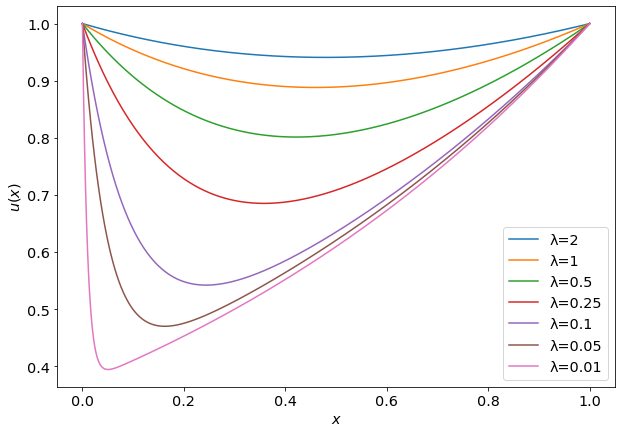

In [ ]:
#@title Plotting function for u(x).
def ua(λ,x):
  m1=(-1+np.sqrt(1+4*λ))/(2*λ)
  m2=(-1-np.sqrt(1+4*λ))/(2*λ)
  num= (np.exp(m2)-1)*np.exp(m1*x) +(1-np.exp(m1))*np.exp(m2*x)
  denom=np.exp(m2)-np.exp(m1)
  return num/denom

def plotU(λ):
  ex=np.linspace(0,1,500,endpoint=True)
  plt.figure(figsize=(10,7))
  for i in range(len(λ)):
    u=ua(λ[i],ex)
    plt.plot(ex,u,label="λ="+str(λ[i]))
  plt.xlabel('$x$')
  plt.ylabel('$u(x)$')
  plt.legend()
  plt.show()

    
λ=[2,1,0.5,0.25,0.1,0.05,0.01]
plotU(λ)

As can be seen above, as λ gets smaller, the boundary at $x=0$ becomes more difficult to resolve therefore we expect the routine to return meshes that are more dense at $x=0$ for smaller values of λ.

In [ ]:
#@title Construct $u$, $u'$, $u''$, $M$ and $\frac{dM}{dx}$
def U(λ,x):
  m1=(-1+np.sqrt(1+4*λ))/(2*λ)
  m2=(-1-np.sqrt(1+4*λ))/(2*λ)
  num= (np.exp(m2)-1)*np.exp(m1*x) +(1-np.exp(m1))*np.exp(m2*x)
  denom=np.exp(m2)-np.exp(m1)
  return num/denom


def Ux(λ,x):
  m1=(-1+np.sqrt(1+4*λ))/(2*λ)
  m2=(-1-np.sqrt(1+4*λ))/(2*λ)
  num= m1*(np.exp(m2)-1)*np.exp(m1*x) +m2*(1-np.exp(m1))*np.exp(m2*x)
  denom=np.exp(m2)-np.exp(m1)
  return num/denom

def Uxx(λ,x):
  m1=(-1+np.sqrt(1+4*λ))/(2*λ)
  m2=(-1-np.sqrt(1+4*λ))/(2*λ)
  num= m1**2*(np.exp(m2)-1)*np.exp(m1*x) +m2**2*(1-np.exp(m1))*np.exp(m2*x)
  denom=np.exp(m2)-np.exp(m1)
  return num/denom

def M(λ,x,ux):
  return np.sqrt(1+ux(λ,x)**2)

def dM(λ,x,ux,uxx):
  return (ux(λ,x)*uxx(λ,x))/np.sqrt(1+ux(λ,x)**2)


In [ ]:
#@title Construct $\textbf{G}$ and $\textbf{J}$
def makeG(x,M,λ,ux):
  N= len(x)
  G=np.zeros(N-2)
  #1/(2*dexi**2)*
  for i in range(1,N-1):
    G[i-1]= (  (M(λ,x[i+1],ux) +  M(λ,x[i],ux))   * (x[i+1] - x[i])- \
                          (   M(λ,x[i],ux)   +  M(λ,x[i-1],ux)) * (x[i]   - x[i-1])  \
                          )
  return G


def mydiag(λ,M,dM,x,xPlus1,xMinus1,ux,uxx):
  gixi= -2*M(λ,x,ux) -M(λ,xMinus1,ux)-M(λ,xPlus1,ux)+ dM(λ,x,ux,uxx)*(xPlus1-2*x+xMinus1)
  return gixi

def subDiag(λ,M,dM,x,xMinus1,ux,uxx):
  return M(λ,x,ux)+M(λ,xMinus1,ux) +dM(λ,xMinus1,ux,uxx)*(xMinus1-x)

def supDiag(λ,M,dM,x,xPlus1,ux,uxx):
  return M(λ,xPlus1,ux) +M(λ,x,ux) +dM(λ,xPlus1,ux,uxx)*(xPlus1-x)

def makeJ(x,M,dM,λ,ux,uxx):
  dim=len(x)-2
  exi=x
  dexi=exi[1]-exi[0]
  J= np.zeros(dim*dim).reshape((dim,dim))
  #print(mydiag(C,M,dM,x[1],x[2],x[0]))
  #first row
  J[0][0]=mydiag(λ,M,dM,x[1],x[2],x[0],ux,uxx)
  J[0][1]= supDiag(λ,M,dM,x[1],x[2],ux,uxx)
  #last row
  J[-1][-1]=mydiag(λ,M,dM,x[-2],x[-1],x[-3],ux,uxx)
  J[-1][-2] = subDiag(λ,M,dM,x[-2],x[-3],ux,uxx)

  for i in range(1,len(J)-1):

    J[i][i]   = mydiag(λ,M,dM, x[i+1],x[i+2],x[i],ux,uxx)
    J[i][i-1] = subDiag(λ,M,dM,x[i+1],       x[i],ux,uxx)
    J[i][i+1] = supDiag(λ,M,dM,x[i+1],x[i+2]     ,ux,uxx)
  return J

In [ ]:
#@title Newton solver
def Newton(ex,λ,M,dM,ux,uxx):
  G=makeG(ex,M,λ,ux)
  J=makeJ(ex,M,dM,λ,ux,uxx)
  delta=linalg.solve(J,G)
  norm = np.abs(np.amax(delta))
  xnew=np.zeros(len(ex))
  xnew[-1]=1
  xnew[1:-1]= ex[1:-1]-delta
  
  while (norm>10**-6):
    G=makeG(xnew,M,λ,ux)
    J=makeJ(xnew,M,dM,λ,ux,uxx)
    delta=linalg.solve(J,G)
    xnew[1:-1]= xnew[1:-1]-delta
    norm = np.abs(np.amax(delta))
    
  return xnew

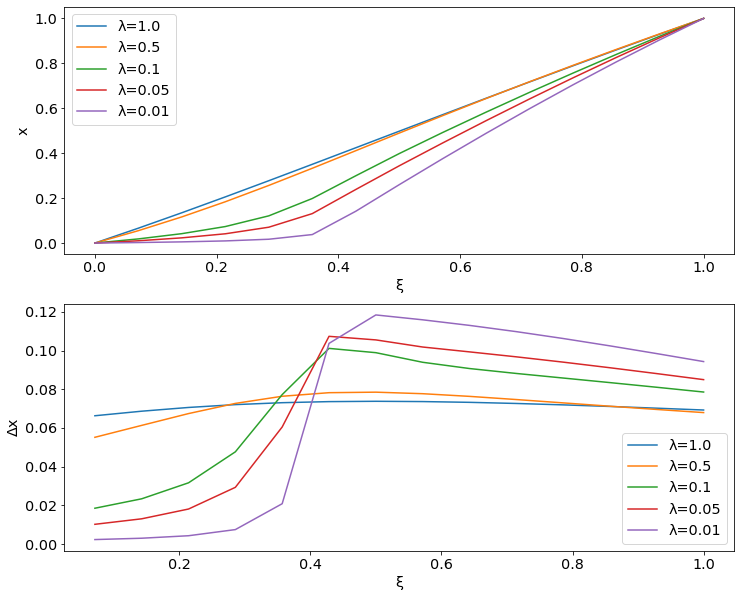

In [ ]:
#@title Main

def main(ex,λ,M,dM,Ux,Uxx):
 
  fig, (ax1,ax2) = plt.subplots(2,figsize=(12,10))
  for i in range(len(λ)):
    xnew= Newton(ex,λ[i],M,dM,Ux,Uxx)
    dex= getDeltas(xnew)
    ax1.plot(ex,xnew,label='λ='+str(λ[i]))
    ax2.plot(ex[1:],dex,label='λ='+str(λ[i]))
  ax1.set(xlabel='ξ',ylabel='x')
  ax2.set(xlabel='ξ',ylabel='Δx')
  ax1.legend()
  ax2.legend()
  plt.show()

λ=np.array([0.01,0.05,0.1,0.5,1])
λ=np.flip(λ)
main(ex,λ,M,dM,Ux,Uxx)

Let us try and break the algorithm by making $λ$ smaller and smaller.

In [ ]:
ex=np.linspace(0,1,N,endpoint=True)
Newton(ex,0.004,M,dM,Ux,Uxx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=5.53048e-20): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=7.25713e-20): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=4.8374e-19): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=1.94452e-18): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=5.22372e-18): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=1.42037e-17): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlg

array([0.00000000e+00, 9.54951716e-04, 2.20955764e-03, 4.03361535e-03,
       7.31824813e-03, 1.73724822e-02, 1.06943402e-01, 2.30391573e-01,
       3.51208707e-01, 4.68982463e-01, 5.83313584e-01, 6.93840788e-01,
       8.00263936e-01, 9.02361550e-01, 1.00000000e+00])

We get a few warnings for λ=0.004 since the points are clustering closer and closer together.

In [ ]:
Newton(ex,0.003,M,dM,Ux,Uxx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=1.40895e-25): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars


ValueError: ignored

λ=0.003 broke it, perhaps if we increase the number of mesh points it will improve our convergence.

In [ ]:
ex=np.linspace(0,1,150,endpoint=True)
Newton(ex,0.003,M,dM,Ux,Uxx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=2.54799e-19): result may not be accurate.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow

ValueError: ignored

Nope. 

Instead of conducting our initial iteration of the Newton solver with a uniform mesh, we do the following.
## Modification to algorithm for improved convergence.
1. Select a value for $λ$, call it $λ_j$, for which the boundary is not too sharp such that convergence is guaranteed.

2. Once a mesh ${\{x\}_{λ_j}}$ for that $λ_j$ is found, select a smaller value for $λ$, call it $λ_{j+1}$.

3. Run the Newton solving routine using $λ_{j+1}$ but now initialized with the mesh ${\{x\}_{λ_j}}$ instead of the uniform mesh.

4. Repeat steps $2$ and $3$ untill the desired value of $λ$ is reached or convergence is not possible. 

In [ ]:
def iterateC(ex,C,M,dM,Ux,Uxx):
  exes=[]
  x=ex
  fig, (ax1,ax2) = plt.subplots(2,figsize=(12,10))
  for i in range(len(C)):
    x= Newton(x,C[i],M,dM,Ux,Uxx)
    dex= getDeltas(x)
    ax1.plot(ex,x,label='λ='+str(C[i]))
    ax2.plot(ex[1:],dex,label='λ='+str(C[i]))

  ax1.set(xlabel='ξ',ylabel='x')
  ax2.set(xlabel='ξ',ylabel='Δx')

  ax1.legend()
  ax2.legend()
  plt.show()
  return x

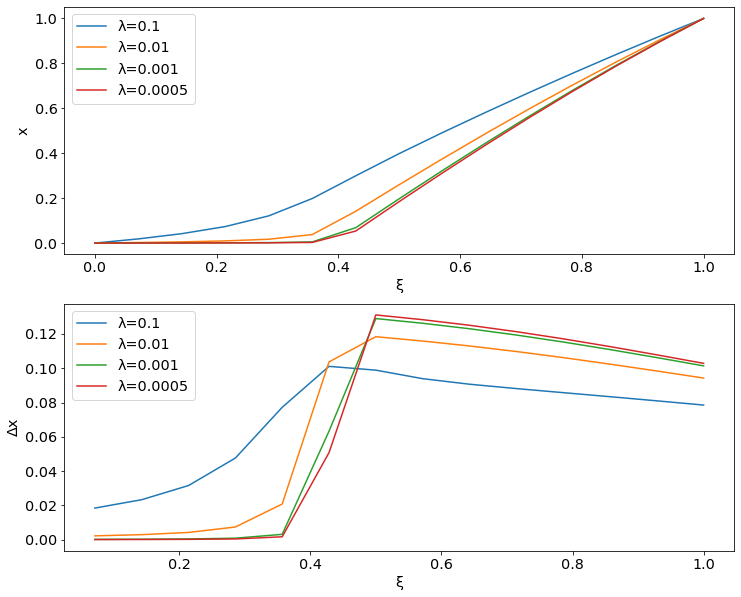

In [ ]:
ex=np.linspace(0,1,15,endpoint=True)
λ=np.array([0.0005,0.001,0.01,0.1])
λ=np.flip(λ)
x=iterateC(ex,λ,M,dM,Ux,Uxx)

Quite an improvement! We are able to go get a mesh with a $λ$ of $0.0005$ compared to the minimum of $0.003$ with an inititial uniform mesh.

A fun project btw, thank you!